# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
19331,27331,72283,"Colorado Springs, CO",26-03-2020,Gas prices in Colorado Springs could fall anot...,Negative
22771,31624,76576,"Cobham, Surrey KT11 3NE",03-04-2020,We couldn't have put it better. From team #NHS...,Extremely Positive
25881,35497,80449,periphery always the periphery,07-04-2020,The collective response to the pandemic from p...,Extremely Negative
23304,32274,77226,"Burlington, Ontario",04-04-2020,Cant believe this has to be said but I keep he...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [4]:
mark = {'Positive':1, 'Extremely Positive':1, 'Negative':0, 'Extremely Negative':0}
df['Sentiment'] = df['Sentiment'].map(mark)

Сбалансированы ли классы?

In [5]:
positive = df['Sentiment'].value_counts()[1]/len(df['Sentiment'])*100
nevative = df['Sentiment'].value_counts()[0]/len(df['Sentiment'])*100
print(f'positive - {positive:.1f}% \nnevative - {nevative:.1f}%')

positive - 54.0% 
nevative - 46.0%


**Ответ:** Да



Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       26395 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


In [7]:
df['Location'] = df['Location'].fillna('Unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       33444 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [14]:
import nltk
nltk.download('punkt')
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
dictionary = Counter()
for text in train['OriginalTweet']:
    tokens = text.lower().split()
    dictionary.update(tokens)

Какой размер словаря получился?

In [48]:
len(dictionary)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [49]:
dictionary = sorted(dictionary.items(), key=lambda x: x[1])
print(dictionary[-10:])
dictionary = dict(dictionary)

[('are', 7050), ('is', 7383), ('#coronavirus', 8223), ('for', 8566), ('in', 11198), ('a', 11737), ('of', 13012), ('and', 14684), ('to', 23373), ('the', 26815)]


**Ответ:** Предлоги, артикли, специальные символы: #, @. Их использование в речи происходит чаще. Выделяется "#coronavirus", что является особенностью этих данных.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [50]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
dictionary = Counter()
for text in train['OriginalTweet']:
    tokens = text.lower().split()
    tokens = [token for token in tokens if not token in set(stopwords.words('english'))]
    dictionary.update(tokens)

In [52]:
dictionary = sorted(dictionary.items(), key=lambda x: x[1])
print(dictionary[-10:])

[('&amp;', 2314), ('#covid19', 2471), ('store', 3155), ('covid-19', 3173), ('people', 3175), ('supermarket', 3288), ('grocery', 3469), ('food', 3820), ('prices', 3891), ('#coronavirus', 8223)]


**Ответ:**  Сейчас вывод уже лучше, можно понять, о чем вообще твитты датасета: короновирус, проблемы людей в это время, ситуация с ценами и едой.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [53]:
print(dictionary[:20])

[('https://t.co/1m881cwfuv', 1), ('happy..', 1), ('https://t.co/z0intks34x', 1), ('mnuchinã\x82â\x92s', 1), ('brink.', 1), ('https://t.co/jmobv8z0u0', 1), ("university's", 1), ('teaching.)', 1), ('@catholicpres', 1), ('@catholicuniv', 1), ('https://t.co/evqby035wf', 1), ('https://t.co/riqrhxxeim', 1), ('@@ballardspahrll', 1), ('#aca', 1), ('easier...take', 1), ('ã\x82â\x93necessaryã\x82â\x94', 1), ('https://t.co/0fmsmlgepm', 1), ('husted:', 1), ('irishman', 1), ('#happystpatricksday!', 1)]


**Ответ:** Единождое упоминание в твитах, ссылки, хэштега, автоматически делает токен не важным для определения тональности.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [54]:
from nltk.tokenize import TweetTokenizer

dictionary = Counter()
for text in train['OriginalTweet']:
    tokens = TweetTokenizer().tokenize(text.lower())
    dictionary.update(tokens)

In [55]:
dictionary = sorted(dictionary.items(), key=lambda x: x[1])
print(dictionary[-10:])

[('#coronavirus', 8808), ('?', 9524), ('in', 11348), ('a', 11891), ('of', 13044), ('and', 14825), (',', 17571), ('to', 23478), ('.', 24118), ('the', 26993)]


**Ответ:** Токенайзер отделил от слов знаки препенания, которые нам не принесут пользы, их нужно удалить

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [56]:
from string import punctuation
dictionary = Counter()
for text in train['OriginalTweet']:
    tokens = TweetTokenizer().tokenize(text.lower())
    tokens = [token for token in tokens if not token in set(stopwords.words('english')) and not token in punctuation]
    dictionary.update(tokens)
dictionary = sorted(dictionary.items(), key=lambda x: x[1])
print(dictionary[-10:])

[('supermarket', 3805), ('store', 3877), ('food', 4367), ('\x92', 4372), ('prices', 4601), ('covid', 6253), ('19', 7167), ('\x82', 7311), ('â', 7415), ('#coronavirus', 8808)]


**Ответ:**  Остались одиночные символы, символы юникода

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [57]:
dictionary = Counter()
for text in train['OriginalTweet']:
    tokens = TweetTokenizer().tokenize(text.lower())
    tokens = [token for token in tokens if not token in set(stopwords.words('english')) and not token in punctuation and not (len(token) ==  1 and ord(token))]
    dictionary.update(tokens)
dictionary = sorted(dictionary.items(), key=lambda x: x[1])
print(dictionary[-10:])
print(dictionary[:20])

[('#covid19', 2589), ('people', 3463), ('grocery', 3523), ('supermarket', 3805), ('store', 3877), ('food', 4367), ('prices', 4601), ('covid', 6253), ('19', 7167), ('#coronavirus', 8808)]
[('https://t.co/1m881cwfuv', 1), ('https://t.co/z0intks34x', 1), ('mnuchinã', 1), ('https://t.co/jmobv8z0u0', 1), ("university's", 1), ('@catholicpres', 1), ('@catholicuniv', 1), ('https://t.co/evqby035wf', 1), ('https://t.co/riqrhxxeim', 1), ('@ballardspahrll', 1), ('#aca', 1), ('https://t.co/0fmsmlgepm', 1), ('irishman', 1), ('#happystpatricksday', 1), ('guiness', 1), ('https://t.co/18v0pyhwb7', 1), ('https://t.co/ls0g86i8pu', 1), ('https://t.co/ofvkejff23', 1), ('https://t.co/xoodgd2ulx', 1), ('lifestyles', 1)]


**Ответ:** Топ популярных слов состоит из целостных, смыловых слов, в непопулярных, по прежнему есть ссылки, хэштеги.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [59]:
hashtag = Counter()
for text in train['OriginalTweet']:
    tokens = TweetTokenizer().tokenize(text.lower())
    tokens = [token for token in tokens if token[0]=='#']
    hashtag.update(tokens)
hashtag = sorted(hashtag.items(), key=lambda x: x[1])
print(hashtag[-10:])

[('#coronaviruspandemic', 249), ('#pandemic', 257), ('#coronacrisis', 448), ('#socialdistancing', 465), ('#covid', 641), ('#toiletpaper', 744), ('#covid2019', 946), ('#covid_19', 1734), ('#covid19', 2589), ('#coronavirus', 8808)]


**Ответ:** Все хэштеги короновирусных времен

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [61]:
link = Counter()
for text in train['OriginalTweet']:
    tokens = TweetTokenizer().tokenize(text.lower())
    tokens = [token for token in tokens if 'https://t.co' in token]
    link.update(tokens)
link = sorted(link.items(), key=lambda x: x[1])
print(link[-10:])

[('https://t.co/3gbbdpdjat', 3), ('https://t.co/e2znxajpre', 3), ('https://t.co/catkegayoy', 3), ('https://t.co/g63rp042ho', 3), ('https://t.co/aziqcdgrnn', 3), ('https://t.co/bylqxrjmnt', 3), ('https://t.co/wuieefsnoj', 3), ('https://t.co/oi39zsanq8', 3), ('https://t.co/gp3eusapl8', 4), ('https://t.co/oxa7swtond', 5)]


**Ответ:** Ссылки очень редки, различны и врядли по ним можно выявить тональность.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [62]:
def custom_tokenizer(text):
  from nltk.tokenize import TweetTokenizer
  token = TweetTokenizer().tokenize(text.lower())
  token = [word for word in token if word not in stopwords.words('english')]
  token = [word for word in token if word not in punctuation]
  token = [word for word in token if not (len(word)==1 and ord(word) > 127)]
  token = [word for word in token if 'https://t.co' not in word]
  return token


In [63]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45306


**Ответ:** Уменьшиля почти в 2 раза.

Посмотрим на какой-нибудь конкретный твитт:

In [65]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [84]:
custom_tokenizer(train.iloc[ind]['OriginalTweet'])

['nice',
 'one',
 '@skynews',
 'lets',
 'panic',
 'show',
 'ppl',
 'france',
 'queueing',
 'food',
 '#coronavirusoutbreak',
 '#covid2019',
 'brainless',
 'ffs']

Наверное хотелось бы получить что-то вроде: nice, panic, brainless -важно, ffs, show, covid-неважно

In [67]:
count_vector = cv.transform([train.iloc[ind]['OriginalTweet']])
count_vector_max = count_vector.toarray().argmax()
count_vector_min = count_vector.toarray().argmin()

In [82]:
voc = dict(cv.vocabulary_.items())
token_max = list(voc.keys())[list(voc.values()).index(count_vector_max)]
token_min = list(voc.keys())[list(voc.values()).index(count_vector_min)]
print(token_max, token_min, sep='\n')

#coronavirusoutbreak
###covid-19


**Ответ:** Важный и неважный токен схожи и оба не отражают тональность текста

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_v=TfidfVectorizer(tokenizer=custom_tokenizer)
tf_idf_v.fit(train['OriginalTweet'])
tf_idf_vector = tf_idf_v.transform([train.iloc[ind]['OriginalTweet']])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [99]:
tfid_vector_max = tf_idf_vector.toarray().argmax()
tfid_vector_min = tf_idf_vector.toarray().argmin()
voc_t = dict(tf_idf_v.vocabulary_.items())
token_max_t = list(voc_t.keys())[list(voc_t.values()).index(tfid_vector_max)]
token_min_t = list(voc_t.keys())[list(voc_t.values()).index(tfid_vector_min)]
print(token_max_t, token_min_t, sep='\n')

brainless
###covid-19


**Ответ:**Теперь по важному токену можно определить тональность, что не может ни радовать.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [136]:
train[train['OriginalTweet'].apply(lambda x: 'great' in x) & (train['Sentiment'] == 1)].sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10107,16065,61017,global,21-03-2020,NHS staff definitely front line troops but a s...,1
32932,44296,89248,Unknown,13-04-2020,With everyone limiting their trips to the groc...,1
9194,14955,59907,Ireland | UK | Luxembourg,20-03-2020,"VR headset companies, now is the time to slash...",1
32712,44039,88991,Unknown,13-04-2020,@KylieJenner thank you for your generous donat...,1
16118,23424,68376,Gambia,24-03-2020,is not a cure but it reduces the risk of respi...,1
29117,39534,84486,Ohio,09-04-2020,Trip to the grocery store or great train robbe...,1
8534,14172,59124,"East Yorkshire, UK",20-03-2020,"Yeah sex is great, but I just managed to buy b...",1
15979,23240,68192,"Washington, DC",24-03-2020,Price transparency is so important for the peo...,1
19946,28116,73068,"San Francisco, CA",26-03-2020,Even little things can be perceived as tacky a...,1
28693,39015,83967,Unknown,08-04-2020,"Thanks Pat Hickey for my new Covid 19 mask, wo...",1


In [144]:
print(train.loc[32712]["OriginalTweet"])
custom_tokenizer(train.loc[32712]["OriginalTweet"])


#supportnurses #KylieJenner #Tru


['@kyliejenner',
 'thank',
 'generous',
 'donation',
 'hand',
 'sanitizer',
 'west',
 'hills',
 'hospital',
 'greatly',
 'appreciate',
 'please',
 'help',
 'us',
 'fight',
 'hazard',
 'pay',
 'part',
 'phase',
 'four',
 'coronavirus',
 'relief',
 'bill',
 '#vote',
 '#supportnurses',
 '#kyliejenner',
 '#tru']

In [143]:
tf_idf_vector = tf_idf_v.transform([train.loc[32712]['OriginalTweet']])
tfid_vector_max = tf_idf_vector.toarray().argmax()
tfid_vector_min = tf_idf_vector.toarray().argmin()
voc_t = dict(tf_idf_v.vocabulary_.items())
token_max_t = list(voc_t.keys())[list(voc_t.values()).index(tfid_vector_max)]
token_min_t = list(voc_t.keys())[list(voc_t.values()).index(tfid_vector_min)]
print(token_max_t, token_min_t, sep='\n')

#supportnurses
###covid-19


**Ответ:** В твитте выражается благодарность мед. сестрам, и хэштег отражает отношение автора к ним

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [146]:
y_train = train['Sentiment']
X_train = train.drop(['Sentiment'], axis=1)
y_test = test['Sentiment']
X_test = test.drop(['Sentiment'], axis=1)

In [148]:
X_train_cv = cv.transform(X_train['OriginalTweet'])
X_test_cv = cv.transform(X_test['OriginalTweet'])
X_train_tf = tf_idf_v.transform(X_train['OriginalTweet'])
X_test_tf = tf_idf_v.transform(X_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression()
lr_cv.fit(X_train_cv, y_train)
lr_tf = LogisticRegression()
lr_tf.fit(X_train_tf, y_train)

predict_cv_train = lr_cv.predict(X_train_cv)
predict_cv_test = lr_cv.predict(X_test_cv)
accuracy_cv_train = accuracy_score(y_train, predict_cv_train)
accuracy_cv_test = accuracy_score(y_test, predict_cv_test)

predict_tf_train = lr_tf.predict(X_train_tf)
predict_tf_test = lr_tf.predict(X_test_tf)
accuracy_tf_train = accuracy_score(y_train, predict_tf_train)
accuracy_tf_test = accuracy_score(y_test, predict_tf_test)

print('arruracy cv train:', accuracy_cv_train)
print('arruracy cv test:', accuracy_cv_test)
print('arruracy tf train::', accuracy_tf_train)
print('arruracy tf test::', accuracy_tf_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


arruracy cv train: 0.9843656557026912
arruracy cv test: 0.8675503288818018
arruracy tf train:: 0.9254592054677488
arruracy tf test:: 0.8533984452860275


**Ответ:** CountVectorizer показывает результыты лучше как на тренировочных, так и на тестовых данных.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [152]:
from nltk.stem import SnowballStemmer

def custom_stem_tokenizer(text):
  tokens = custom_tokenizer(text)
  tokens = [SnowballStemmer('english').stem(token) for token in tokens]
  return tokens

In [153]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [158]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36650


**Ответ** Размер словаря уменьшился почти на 20% по сравнению с предыдушим токенайзером.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [155]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(train['OriginalTweet'])
tf_idf_v=TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tf_idf_v.fit(train['OriginalTweet'])

TfidfVectorizer(tokenizer=<function custom_stem_tokenizer at 0x7d165a38bd90>)

In [156]:
X_train_cv = cv.transform(X_train['OriginalTweet'])
X_test_cv = cv.transform(X_test['OriginalTweet'])
X_train_tf = tf_idf_v.transform(X_train['OriginalTweet'])
X_test_tf = tf_idf_v.transform(X_test['OriginalTweet'])

In [157]:
lr_cv = LogisticRegression()
lr_cv.fit(X_train_cv, y_train)
lr_tf = LogisticRegression()
lr_tf.fit(X_train_tf, y_train)

predict_cv_train = lr_cv.predict(X_train_cv)
predict_cv_test = lr_cv.predict(X_test_cv)
accuracy_cv_train = accuracy_score(y_train, predict_cv_train)
accuracy_cv_test = accuracy_score(y_test, predict_cv_test)

predict_tf_train = lr_tf.predict(X_train_tf)
predict_tf_test = lr_tf.predict(X_test_tf)
accuracy_tf_train = accuracy_score(y_train, predict_tf_train)
accuracy_tf_test = accuracy_score(y_test, predict_tf_test)

print('arruracy cv train:', accuracy_cv_train)
print('arruracy cv test:', accuracy_cv_test)
print('arruracy tf train::', accuracy_tf_train)
print('arruracy tf test::', accuracy_tf_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


arruracy cv train: 0.9716787697565143
arruracy cv test: 0.8672513454255532
arruracy tf train:: 0.9158052114480991
arruracy tf test:: 0.8560892963922663


**Ответ:** На тренировочных данных качество упало,на тесте немного выросло.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [165]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

36649


**Ответ:** Не получится подобрать нужный параметр, потому что без ограничений на максимум почему то размер словаря вышел 36651. Вообще суть метода: параметр "max_df" ограничивает частоту встреч токена. Некоторые слова, такие как короновирус встречаются, почти в каждом токене, и из-за этого остальные слова встречаются не так часто.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [166]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [167]:
X_train_cv = cv_df.transform(X_train['OriginalTweet'])
X_test_cv = cv_df.transform(X_test['OriginalTweet'])
lr_cv = LogisticRegression()
lr_cv.fit(X_train_cv, y_train)

predict_cv_train = lr_cv.predict(X_train_cv)
predict_cv_test = lr_cv.predict(X_test_cv)
accuracy_cv_train = accuracy_score(y_train, predict_cv_train)
accuracy_cv_test = accuracy_score(y_test, predict_cv_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [168]:
print('arruracy cv train:', accuracy_cv_train)
print('arruracy cv test:', accuracy_cv_test)

arruracy cv train: 0.9284493806065783
arruracy cv test: 0.8677496511859677


**Ответ:** Хоть мы и уменьшили словарь, но качество, осталось тем же.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [169]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [170]:
X_train_sc = scaler.fit_transform(X_train_cv.toarray())
X_test_sc = scaler.transform(X_test_cv.toarray())

lr_cv = LogisticRegression()
lr_cv.fit(X_train_sc, y_train)


predict_cv_train = lr_cv.predict(X_train_cv)
predict_cv_test = lr_cv.predict(X_test_cv)
accuracy_cv_train = accuracy_score(y_train, predict_cv_train)
accuracy_cv_test = accuracy_score(y_test, predict_cv_test)

print('arruracy cv train:', accuracy_cv_train)
print('arruracy cv test:', accuracy_cv_test)

arruracy cv train: 0.7354976505766766
arruracy cv test: 0.7312138728323699


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


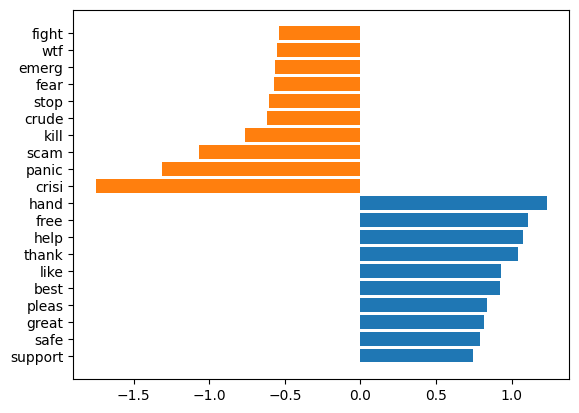

In [177]:
weights = lr_cv.coef_[0]
weights1 = np.argsort(weights)
max_weights_tokens = weights1[-10:]
min_weights_tokens = weights1[:10]


name_tokens = np.array(cv_df.get_feature_names_out())
max_name_tokens = name_tokens[max_weights_tokens]
min_name_tokens = name_tokens[min_weights_tokens]

plt.barh(max_name_tokens, weights[max_weights_tokens])
plt.barh(min_name_tokens, weights[min_weights_tokens])

**Ответ:** Положительной тональности веса имеют положительные веса и наоборот.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [178]:
X_train[["UserName", "ScreenName"]]

,UserName,ScreenName
25621,35178,80130
30135,40819,85771
28899,39249,84201
5989,11068,56020
4367,9109,54061
...,...,...
20757,29120,74072
32103,43291,88243
30403,41159,86111
21243,29702,74654


**Ответ:** Обычно имена и id никак не влияют на данные, как например порядок независимого опроса исследуемых. Поэтому не буем добавлять их в анализ.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [180]:
X_train[['TweetAt']].head(5)

,TweetAt
25621,06-04-2020
30135,10-04-2020
28899,09-04-2020
5989,19-03-2020
4367,18-03-2020


Text(0, 0.5, 'Колличество твиттов')

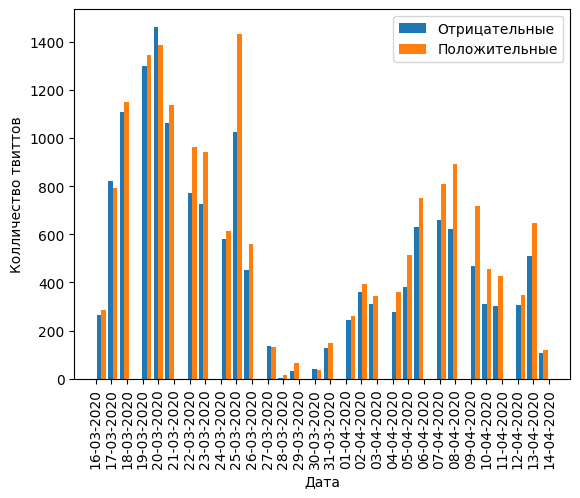

In [188]:
X_train['TweetAt'] = pd.to_datetime(X_train['TweetAt'], format="%d-%m-%Y")

plt.hist([df[df['Sentiment'] == 0]['TweetAt'], df[df['Sentiment'] == 1]['TweetAt']], bins=40, label=['Отрицательные', 'Положительные'])
plt.legend()
plt.xticks(rotation='vertical')
plt.xlabel('Дата')
plt.ylabel('Колличество твиттов')

**Ответ:** В разные пириоды времени положительных и отрицательных твиттов одинаково.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [189]:
df['Location'].nunique()

10465

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<Axes: xlabel='Location'>

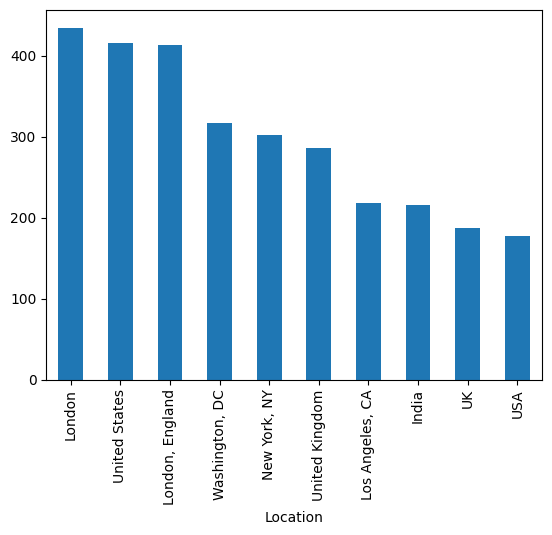

In [207]:
loc = df[df['Location'] != 'Unknown']['Location']
loc.value_counts()[:10].plot(kind='bar')

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [209]:
df['WiderLocation'] = df['Location'].apply(lambda x: x.split(",")[-1].strip())

6118

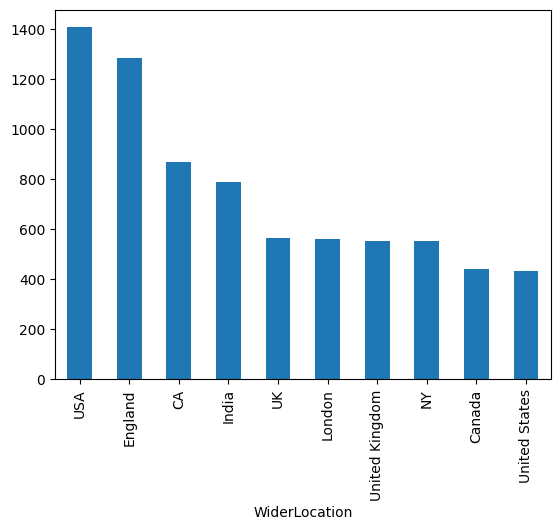

In [211]:
Widerloc = df[df['WiderLocation'] != 'Unknown']['WiderLocation']
Widerloc.value_counts()[:10].plot(kind='bar')
df['WiderLocation'].nunique()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [214]:
location = df['WiderLocation'].value_counts()[df['WiderLocation'].value_counts() > 1].index.tolist()
encoded_data = pd.get_dummies(df['WiderLocation'])
columns_to_drop = [col for col in encoded_data.columns if col not in location]
encoded_data = encoded_data.drop(columns=columns_to_drop)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [215]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Sentiment'], axis=1), df["Sentiment"], test_size=0.3, random_state=0)

X_train_cv = cv_df.transform(X_train['OriginalTweet'])
X_test_cv = cv_df.transform(X_test['OriginalTweet'])

X_train_sc = scaler.fit_transform(X_train_cv.toarray())
X_test_sc = scaler.transform(X_test_cv.toarray())

Train = pd.DataFrame(X_train_sc)
Test = pd.DataFrame(X_test_sc)



In [217]:
lr_cv = LogisticRegression()
lr_cv.fit(Train, y_train)

lr_cv = LogisticRegression()
lr_cv.fit(X_train_sc, y_train)


predict_cv_train = lr_cv.predict(X_train_cv)
predict_cv_test = lr_cv.predict(X_test_cv)
accuracy_cv_train = accuracy_score(y_train, predict_cv_train)
accuracy_cv_test = accuracy_score(y_test, predict_cv_test)

print('arruracy cv train:', accuracy_cv_train)
print('arruracy cv test:', accuracy_cv_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


arruracy cv train: 0.7354976505766766
arruracy cv test: 0.7312138728323699


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# -- YOUR CODE HERE --